# Sigma models on quantum computers: [1903.06577](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.090501)

$$
H = \underbrace{\frac{1}{2\beta} \sum_{k=1}^N \vec{L}_k^2}_{H_0} + \underbrace{\beta \sum_{k=1}^{N-1} ( \vec{n}_{k+1} - \vec{n}_{k})}_{H^\prime_i}
$$

$$
j_1 = \frac{\mathbb{1}\otimes Y}{\sqrt{3}}\quad ,\quad j_2 = \frac{Y\otimes Z}{\sqrt{3}} \quad ,\quad j_3 = \frac{Y\otimes X}{\sqrt{3}}
$$

$$
H_0 = e^{-i\Delta t} \left(\begin{matrix} e^{i\Delta t} & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix}\right)
$$

$$
H^\prime_i = \sum_{q} j_i^q j_i^{q+1}
$$

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import tqdm
np.warnings.filterwarnings("ignore")

In [36]:
def kinetic(circuit, dt, wires):
    circuit.x(wires[0])
    circuit.x(wires[1])
    circuit.cp(dt, wires[0], wires[1])
    circuit.x(wires[0])
    circuit.x(wires[1])
    
def int1(circuit, dt, wires, remove_first_two = False, remove_last_two = False, plot=False):
    if plot:
        circuit.barrier()
        remove_first_two = False
        remove_last_two = False
    if not remove_first_two:
        circuit.s(wires[0])
        circuit.h(wires[0])
    circuit.s(wires[2])
    circuit.h(wires[2])
    circuit.cnot(wires[0], wires[2])
    circuit.p(-2.*dt/3., wires[2])
    circuit.cnot(wires[0], wires[2])
    circuit.h(wires[0])
    circuit.sdg(wires[0])
    if not remove_last_two:
        circuit.h(wires[2])    
        circuit.sdg(wires[2])
    
def int2(circuit, dt, wires, remove_beg = False, remove_fin = False, plot=False):
    if plot:
        circuit.barrier()
        remove_beg = False
        remove_fin = False
    if not remove_beg:
        circuit.s(wires[1])
        circuit.h(wires[1])
        circuit.cnot(wires[0], wires[1])
    
    circuit.s(wires[3])
    circuit.h(wires[3])
    circuit.cnot(wires[2], wires[3])
    
    circuit.cnot(wires[1], wires[3])
    circuit.p(-2.*dt/3., wires[-1])
    circuit.cnot(wires[1], wires[3])
    
    circuit.cnot(wires[0], wires[1])
    circuit.h(wires[1])
    circuit.sdg(wires[1])
    
    if not remove_fin:
        circuit.cnot(wires[2], wires[3])
        circuit.h(wires[3])
        circuit.sdg(wires[3])
        

    
def int3(circuit, dt, wires, remove_beg=False, remove_fin= False, plot=False):
    if plot:
        circuit.barrier()
        remove_beg = False
        remove_fin = False
    if not remove_beg:
        circuit.h(wires[0])
        circuit.s(wires[1])
        circuit.h(wires[1])
        circuit.cnot(wires[0], wires[1])
    
    circuit.h(wires[2])
    circuit.s(wires[3])
    circuit.h(wires[3])
    circuit.cnot(wires[2], wires[3])
    
    circuit.cnot(wires[1], wires[-1])
    circuit.p(-2.*dt/3., wires[-1])
    circuit.cnot(wires[1], wires[-1])
    
    circuit.cnot(wires[0], wires[1])
    circuit.h(wires[0])
    circuit.h(wires[1])
    circuit.sdg(wires[1])

    if not remove_fin:
        circuit.cnot(wires[2], wires[3])
        circuit.h(wires[2])
        circuit.h(wires[3])
        circuit.sdg(wires[3])

In [86]:
dt = 0.1

shots = 4000

PBC = True
plot = False

probs = {"000000" : [], "000001" : [], "111111" : [], "100000" : []}
stat_err = {"000000" : [], "000001" : [], "111111" : [], "100000" : []}
x = []
# Use Aer's qasm_simulator
qasm_sim = QasmSimulator()
aer_sim  = Aer.get_backend("aer_simulator")

if plot:
    time_steps = [0,0.1]
else:
    time_steps = np.linspace(0,4,41)

with tqdm.tqdm(total=len(time_steps)) as pbar:
    for t in time_steps:
        x.append(t)
        pbar.update()

        # Create a Quantum Circuit acting on the q register
        q, c = QuantumRegister(6, "q"), ClassicalRegister(6, "c")
        circuit = QuantumCircuit(q,c)

        for bit in q:
            circuit.h(bit)
        if plot:
            circuit.barrier()

        N = int(t/dt)
        pbar.set_postfix_str(f"t = {t:.1f}, N = {N}")
        
        for step in range(N):

            kinetic(circuit, dt, [q[0],q[1]])
            kinetic(circuit, dt, [q[2],q[3]])
            kinetic(circuit, dt, [q[4],q[5]])

            int1(circuit, dt, [q[0], q[1], q[2], q[3]], remove_last_two=True, plot = plot)
            int1(circuit, dt, [q[2], q[3], q[4], q[5]], remove_first_two=True, remove_last_two=True if PBC else False, plot = plot)

            if PBC: 
                int1(circuit, dt, [q[4], q[5], q[0], q[1]], remove_first_two=True, plot = plot)

            int2(circuit, dt, [q[0], q[1], q[2], q[3]], remove_fin=True, plot = plot)
            int2(circuit, dt, [q[2], q[3], q[4], q[5]], remove_beg=True, remove_fin=True if PBC else False, plot = plot)

            if PBC: 
                int2(circuit, dt, [q[4], q[5], q[0], q[1]], remove_beg=True, plot = plot)

            int3(circuit, dt, [q[0], q[1], q[2], q[3]], remove_fin=True, plot = plot)
            int3(circuit, dt, [q[2], q[3], q[4], q[5]], remove_beg=True, remove_fin=True if PBC else False, plot = plot)

            if PBC: 
                int3(circuit, dt, [q[4], q[5], q[0], q[1]], remove_beg=True, plot = plot)

        if plot:
            circuit.barrier()

        # Map the quantum measurement to the classical bits
        circuit.measure(q, c)

        # compile the circuit down to low-level QASM instructions
        # supported by the backend (not needed for simple circuits)
        compiled_circuit = transpile(circuit, aer_sim)

        # Execute the circuit on the qasm simulator
        job = aer_sim.run(compiled_circuit, shots=shots)

        # Grab results from the job
        result = job.result()

        # Returns counts
        counts = result.get_counts(compiled_circuit)

        for state in probs.keys():
            probs[state].append(counts.get(state, 0.) / shots)
            stat_err[state].append(np.sqrt(counts.get(state, 0.)) / shots)
            
probs= {state: np.array(probs[state]) for state in probs.keys()}
stat_err= {state: np.array(stat_err[state]) for state in probs.keys()}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 10.29it/s, t = 4.0, N = 40]


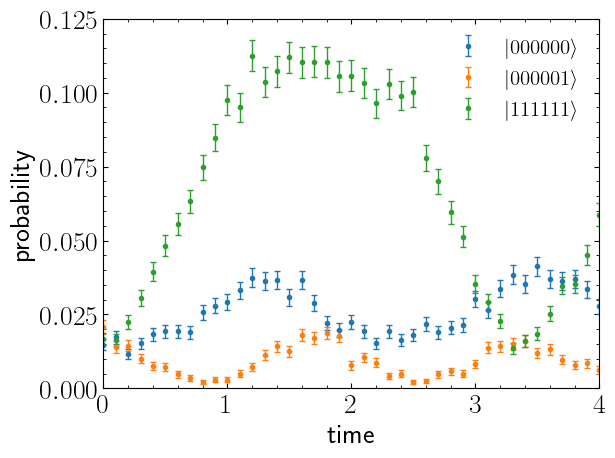

In [88]:
legend = []

plt.errorbar(x , probs["000000"], c = "tab:blue", yerr=stat_err["000000"], fmt=".",capsize=2, elinewidth=1)
legend.append(r"$|000000\rangle$")

plt.errorbar(x , probs["000001"], c = "tab:orange", yerr=stat_err["000001"], fmt=".",capsize=2, elinewidth=1)
legend.append(r"$|000001\rangle$")

plt.errorbar(x , probs["111111"], c = "tab:green", yerr=stat_err["111111"], fmt=".",capsize=2, elinewidth=1)
legend.append(r"$|111111\rangle$")
plt.legend(legend)

plt.ylim([0,0.125])
plt.xlim([0,4])
plt.xlabel("time")
plt.ylabel("probability")

plt.show()